In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
import sys
from pathlib import Path
from time import time
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ROOT_PATH = Path().absolute().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from legacy_frequency_response import LegacyFrequencyResponse
from peq import PEQ, OptimizationHistory, OptimizationFinished
from constants import DEFAULT_FS, PEQ_CONFIGS

In [26]:
np.argmax([0.0, 0.0, 3.0, 0.0])

2

In [101]:
def plot_loss(time, loss, avg, std, fig=None, ax=None):
    time = np.array(time)
    loss = np.array(loss)
    if fig is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(15, 8)
    ax.minorticks_on()
    ax.grid(which='both')
    ax.set_ylabel('dB')
    ax.set_xlabel('Time (s)')
    ax.plot(time, loss, '-o', label='Loss (dB)')
    ix = np.argmax(change != 0.0)
    ix = 0
    ax.plot(time[ix:], avg[ix:], '-o', label='Avg')
    ax.plot(time[ix:], std[ix:], '-o', label='STD')
    ax.legend()
    return fig, ax

In [102]:
def rmse(fr, eq):
    ix10k = np.argmin(np.abs(10000 - fr.frequency))
    return np.sqrt(np.mean(np.square(fr.equalization[:ix10k] - eq[:ix10k])))

In [103]:
def extend_config(config, **optimizer_kwargs):
    config2 = deepcopy(config)
    config2.update({'optimizer': dict(**optimizer_kwargs)})
    return config2

STD too small


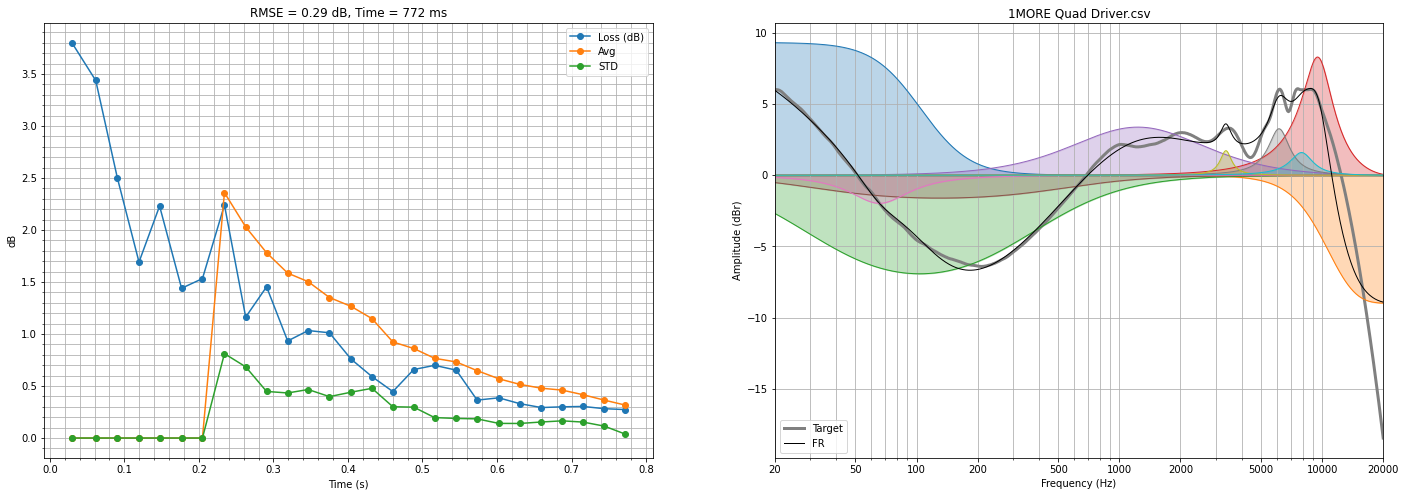

STD too small


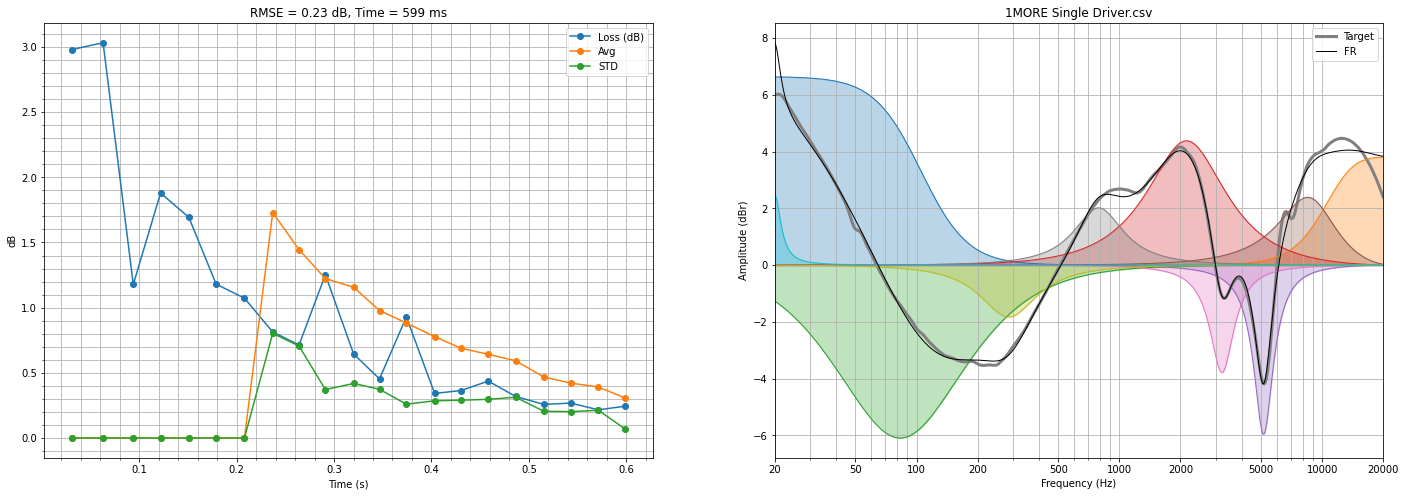

STD too small


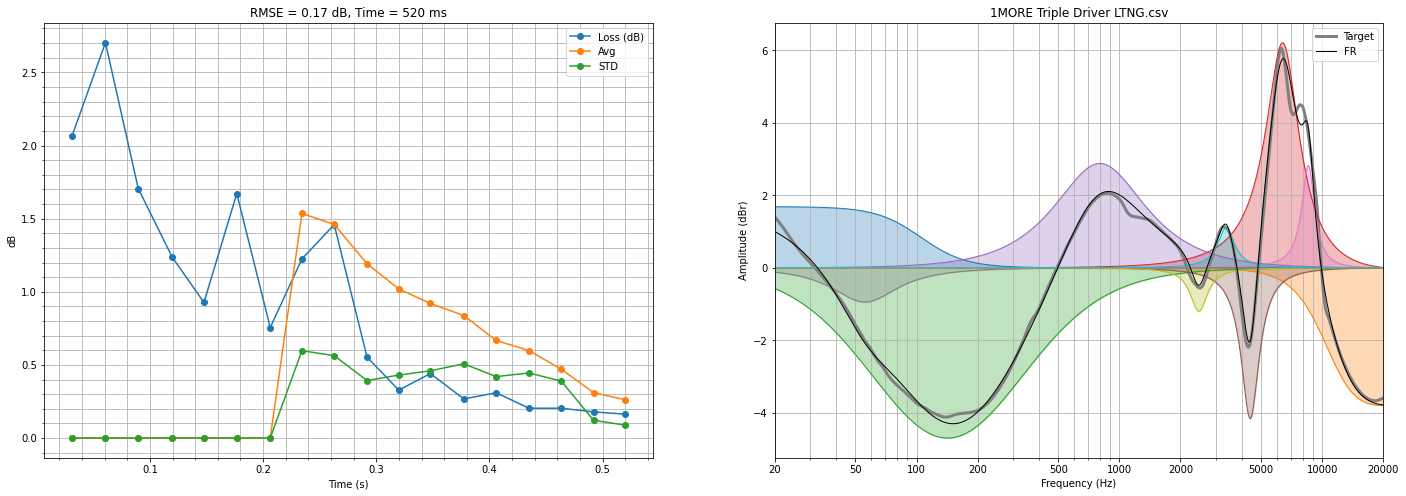

STD too small


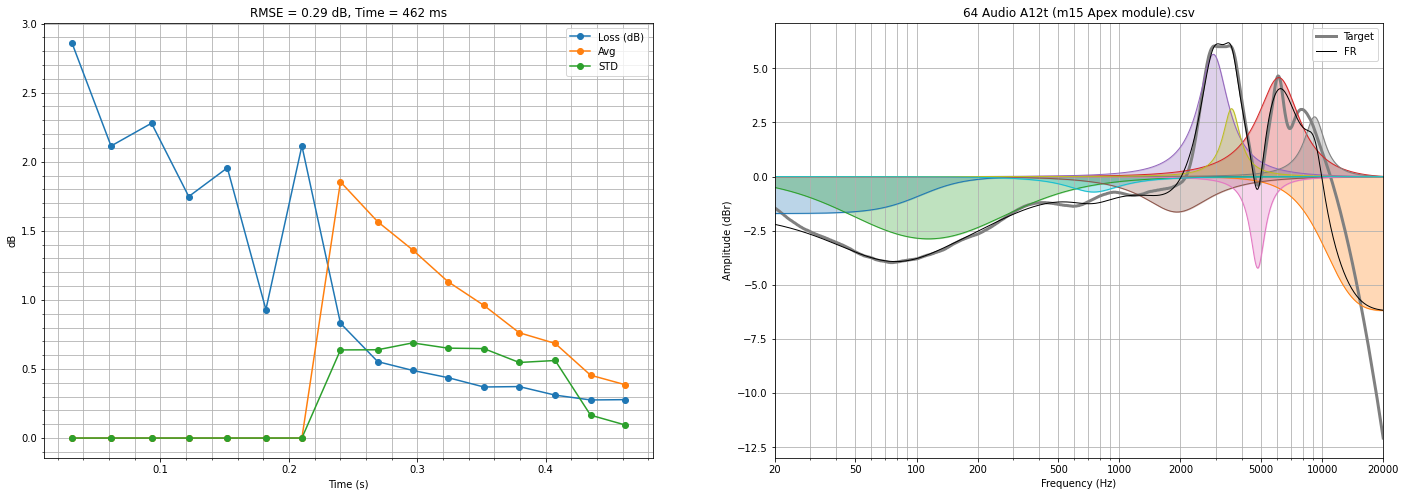

STD too small


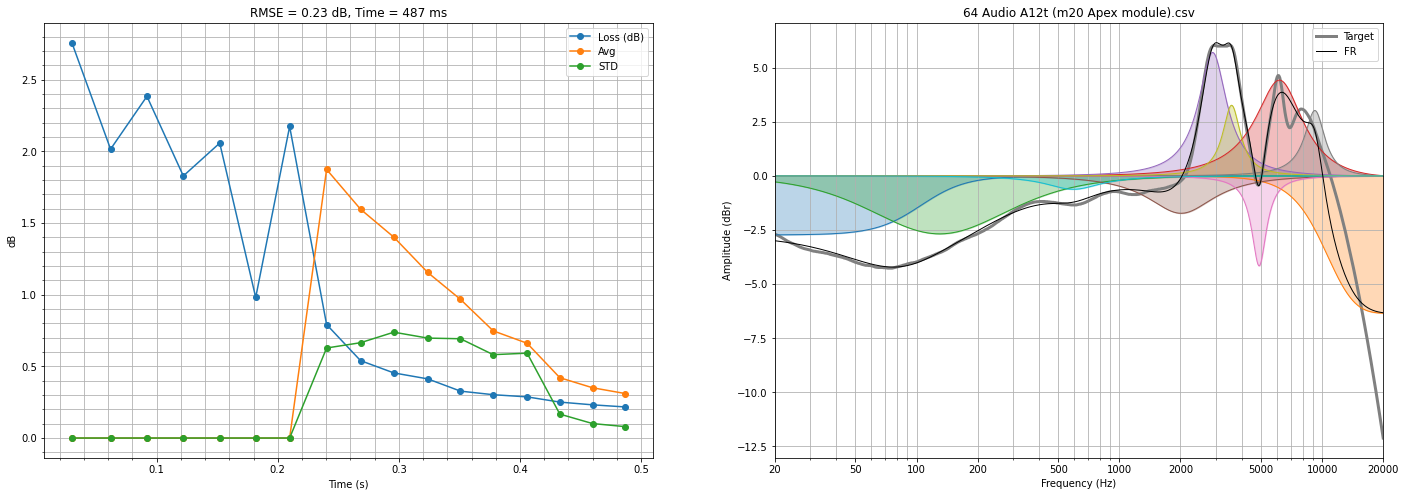

STD too small


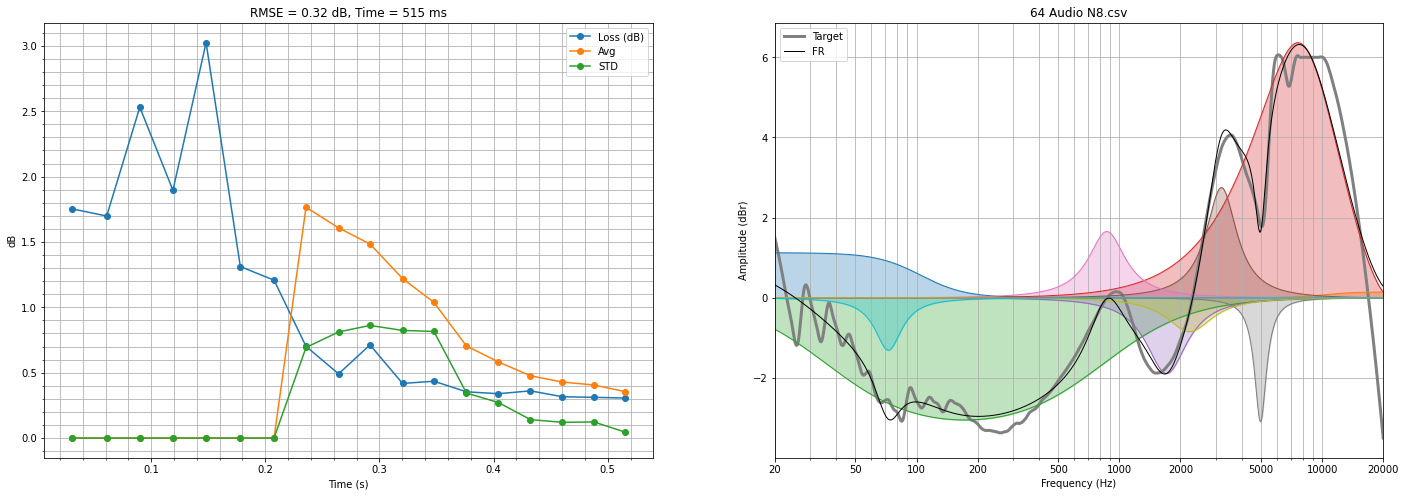

STD too small


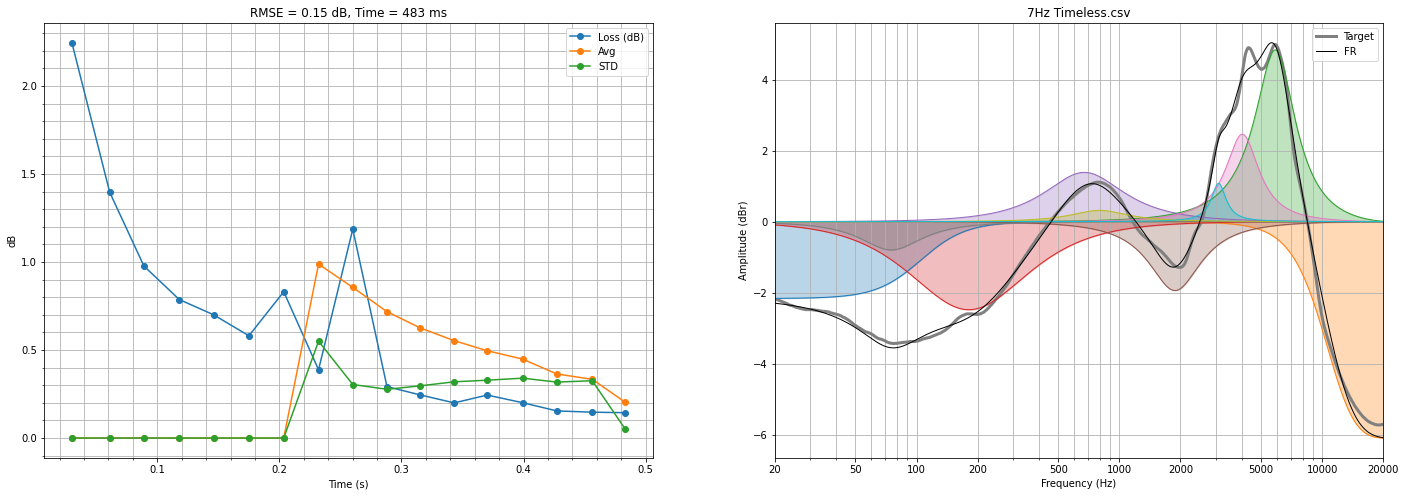

STD too small


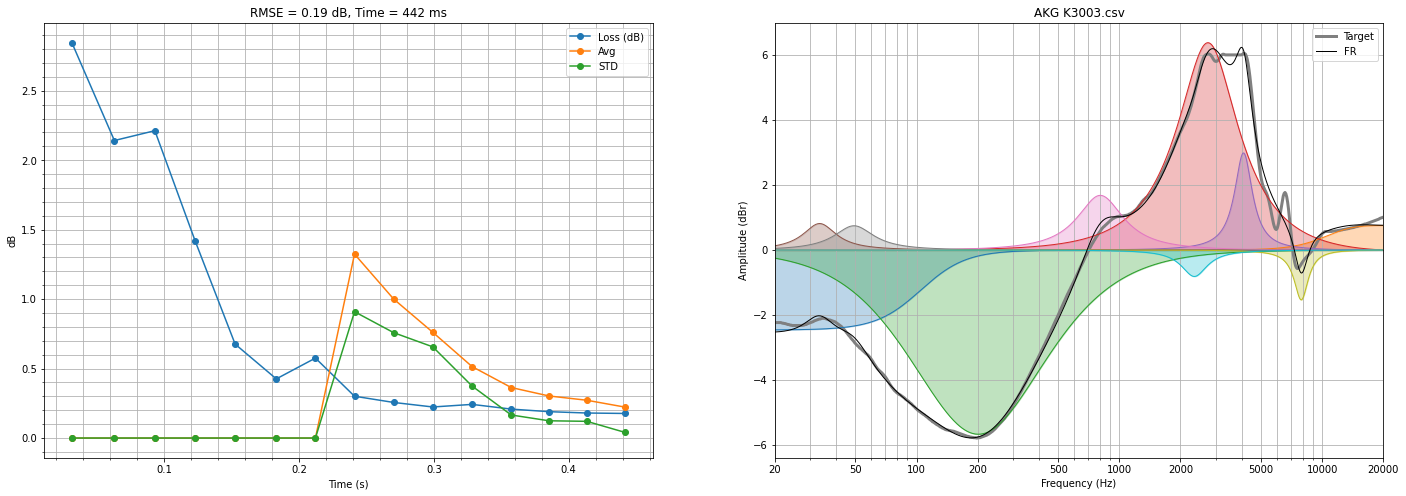

STD too small


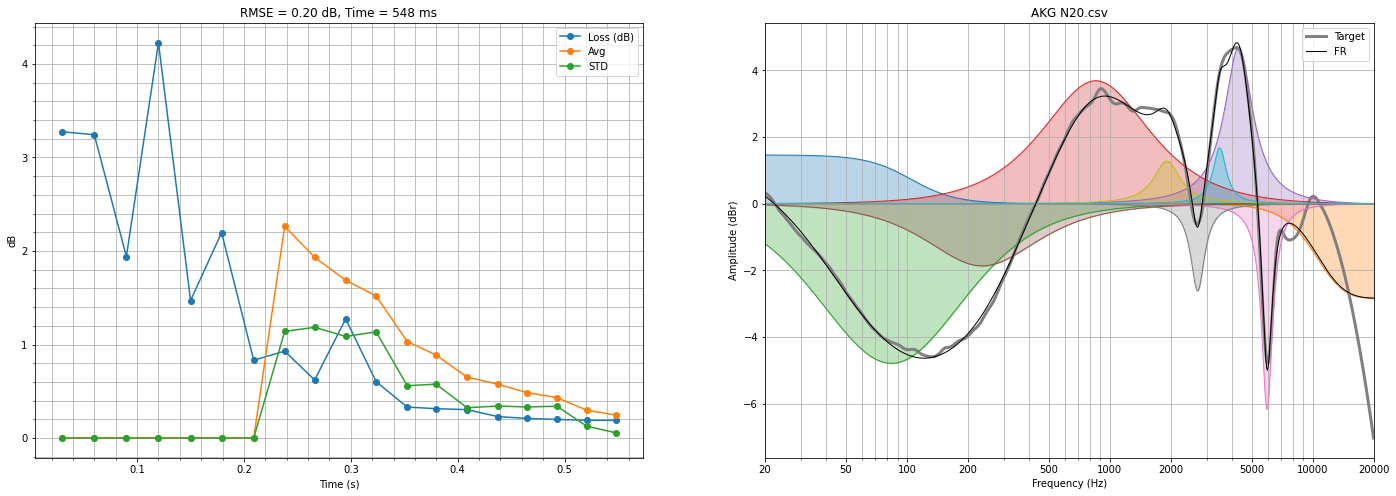

STD too small


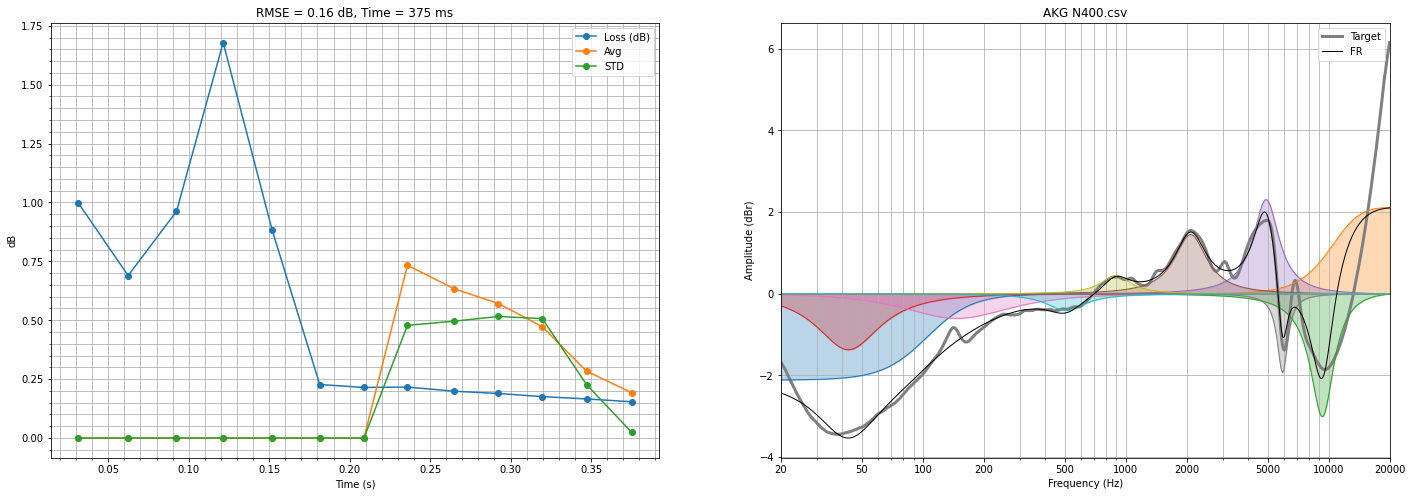

In [110]:
#configs = [PEQ_CONFIGS['4_PEAKING_WITH_LOW_SHELF']]
#configs = [PEQ_CONFIGS['4_PEAKING_WITH_LOW_SHELF'], PEQ_CONFIGS['4_PEAKING_WITH_HIGH_SHELF']]
configs = [PEQ_CONFIGS['8_PEAKING_WITH_SHELVES']]
configs = [extend_config(config, max_time=1) for config in configs]
n = 0
for fp in ROOT_PATH.joinpath('results', 'oratory1990').glob('*/*/*.csv'):
    fr = FrequencyResponse.read_from_csv(fp)
    peqs = fr.optimize_parametric_eq(configs, DEFAULT_FS)
    for i, peq in enumerate(peqs):
        if i > 0:
            peq.history.time = [x + peqs[i-1].history.time[-1] for x in peq.history.time]
    t = np.concatenate([peq.history.time for peq in peqs])
    loss = np.concatenate([peq.history.loss for peq in peqs])
    avg = np.concatenate([peq.history.moving_avg_loss for peq in peqs])
    std = np.concatenate([peq.history.std for peq in peqs])
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(24, 8)
    plot_loss(t, loss, avg, std, fig=fig, ax=axs[0])
    if len(peqs) > 1:
        for i in range(1, len(peqs)):
            for filt in peqs[i].filters:
                peqs[0].add_filter(filt)
    FrequencyResponse.init_plot(fig=fig, ax=axs[1])
    peqs[0].plot(fig=fig, ax=axs[1])
    axs[0].set_title(f'RMSE = {rmse(fr, peqs[0].fr):.2f} dB, Time = {np.sum([peq.history.time[-1] for peq in peqs]) * 1000:.0f} ms')
    axs[1].set_title(f'{fp.name}')
    plt.show()
    n += 1
    if n == 10:
        break